In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout
from tensorflow.keras.losses import mean_squared_error
import plotting_library
import numpy as np

def flatten(matrix, n):
    """
    The images come in as 3D, this turns them into 
    2d in a way that ensures pixels on one axis, spectra on the other
    """
    array = tf.split(matrix, n, axis=1)
    array = [tf.squeeze(i) for i in array]
    return (tf.concat(array, 0))

def encube(matrix):
    """
    Turn the flat matrix back into a cube
    """
    array = tf.split(matrix, 512, axis=1)
    return tf.stack(array, 1)
def normalized_mse(y_true, y_pred):
    """
    Create a custom loss function since keras doesn't have normalized mse
    """
    y_true = tf.cast(y_true, dtype=tf.float32)
    return tf.divide(mean_squared_error(y_true, y_pred),
                      mean_squared_error(y_true, y_true*0))

2023-06-01 12:13:14.659281: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-01 12:13:14.693268: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 12:13:15.237485: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


First we load the model. Note that compile is set to false because if you set it to true there will be an error due to the fact that the model uses a specialized loss function

In [2]:
autoencoder = tf.keras.models.load_model('saved_autoencoder',compile=False)
autoencoder.summary()

2023-06-01 12:13:17.913541: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-06-01 12:13:17.913559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: talia
2023-06-01 12:13:17.913562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: talia
2023-06-01 12:13:17.913693: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 515.105.1
2023-06-01 12:13:17.913704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 515.105.1
2023-06-01 12:13:17.913706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 515.105.1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 262144, 31)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1d (Conv1D)                (None, 262144, 31)   2914        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 262144, 31)   2914        ['conv1d[0][0]']                 
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 131072, 31)   0           ['conv1d_1[0][0]']           

                                                                                                  
 conv1d_26 (Conv1D)             (None, 64, 31)       2914        ['conv1d_25[0][0]']              
                                                                                                  
 max_pooling1d_12 (MaxPooling1D  (None, 32, 31)      0           ['conv1d_26[0][0]']              
 )                                                                                                
                                                                                                  
 conv1d_27 (Conv1D)             (None, 32, 31)       2914        ['max_pooling1d_12[0][0]']       
                                                                                                  
 conv1d_28 (Conv1D)             (None, 32, 31)       2914        ['conv1d_27[0][0]']              
                                                                                                  
 max_pooli

In [3]:
test_images = np.load('test_images.npy')
final_spec = autoencoder.predict(test_images[:10])
cubed_final_spec = encube(final_spec)
cubed_test_images = encube(test_images[:10])

1/1 [==============================] - 1s 1s/step


## Here we see how well the autoencoder can reconstruct individual spectra in the hyperspectral image

1/1 [==============================] - 0s 149ms/step


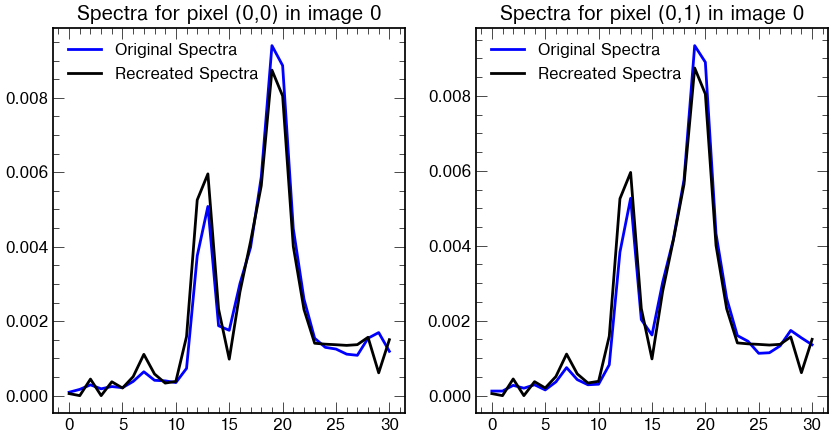

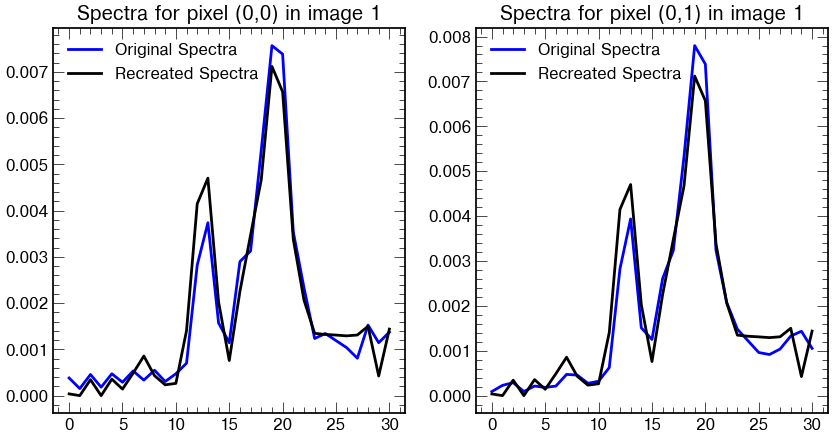

In [13]:
# ## Analyze predictive ability
final_spec = autoencoder.predict(test_images[:10])
cubed_final_spec = encube(final_spec)
cubed_test_images = encube(test_images[:10])
input_img = Input(shape=(262144, 31))


for i in range(2):  
    f, axarr = plt.subplots(1,2, figsize=(10,5))
    
    axarr[0].plot(cubed_test_images[i,0,0,:], color='b', label='Original Spectra')
    axarr[0].plot(cubed_final_spec[i,0,0,:], color='k', label='Recreated Spectra')
    axarr[0].set_title("Spectra for pixel (0,0) in image " + str(i))
    axarr[0].legend()
    
    axarr[1].plot(cubed_test_images[i,0,1,:], color='b', label='Original Spectra')
    axarr[1].plot(cubed_final_spec[i,0,0,:], color='k', label='Recreated Spectra')
    axarr[1].set_title("Spectra for pixel (0,1) in image " + str(i))
    axarr[1].legend()

    plt.savefig('images/spectra_reconstruction')

As you can see here, the distribution of the spectra isn't supper accurate, but that is okay, it's not what is being optimized for

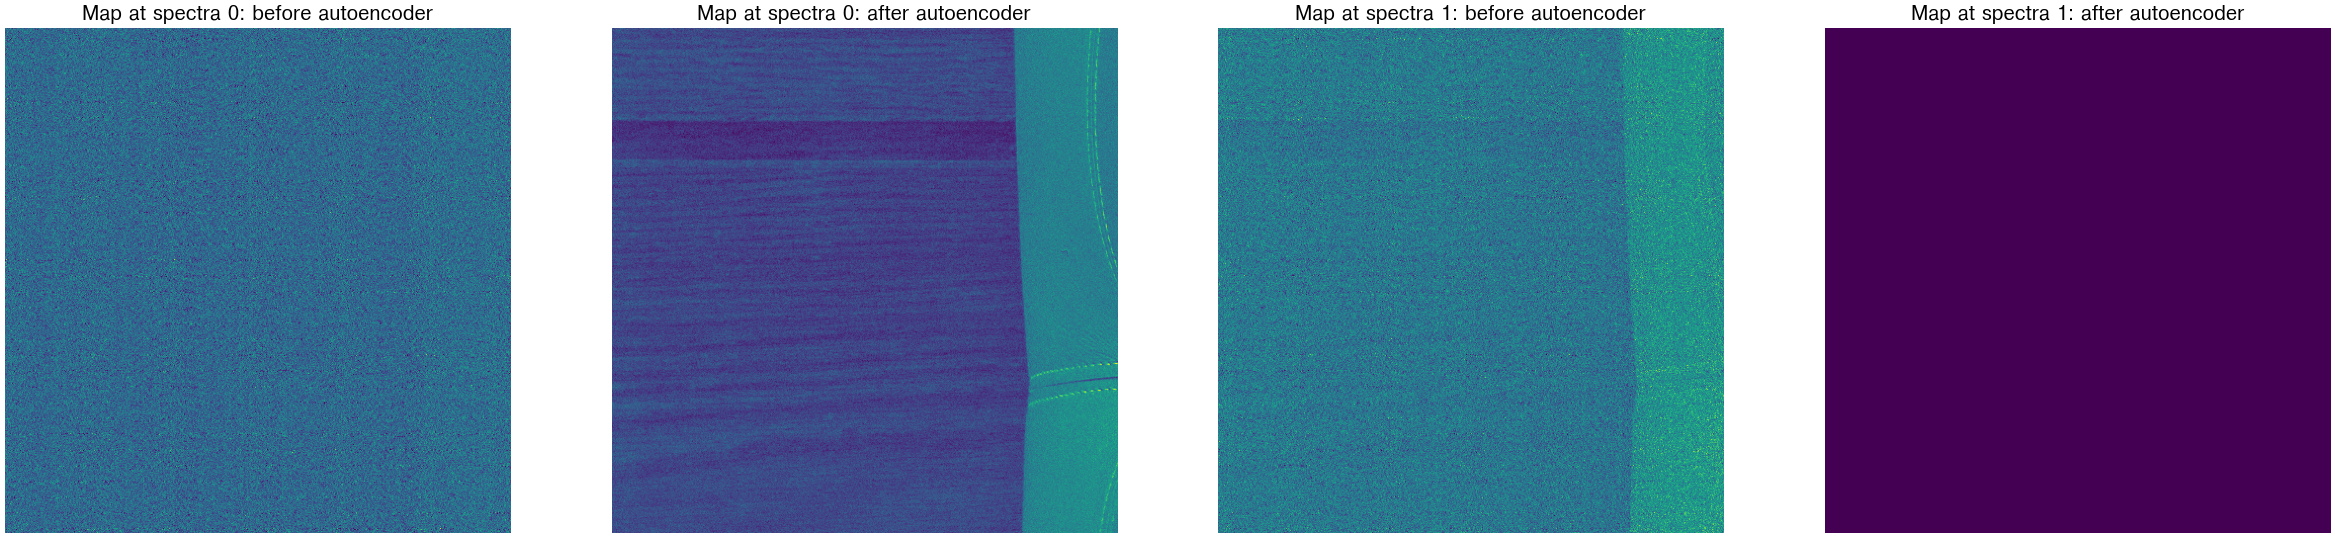

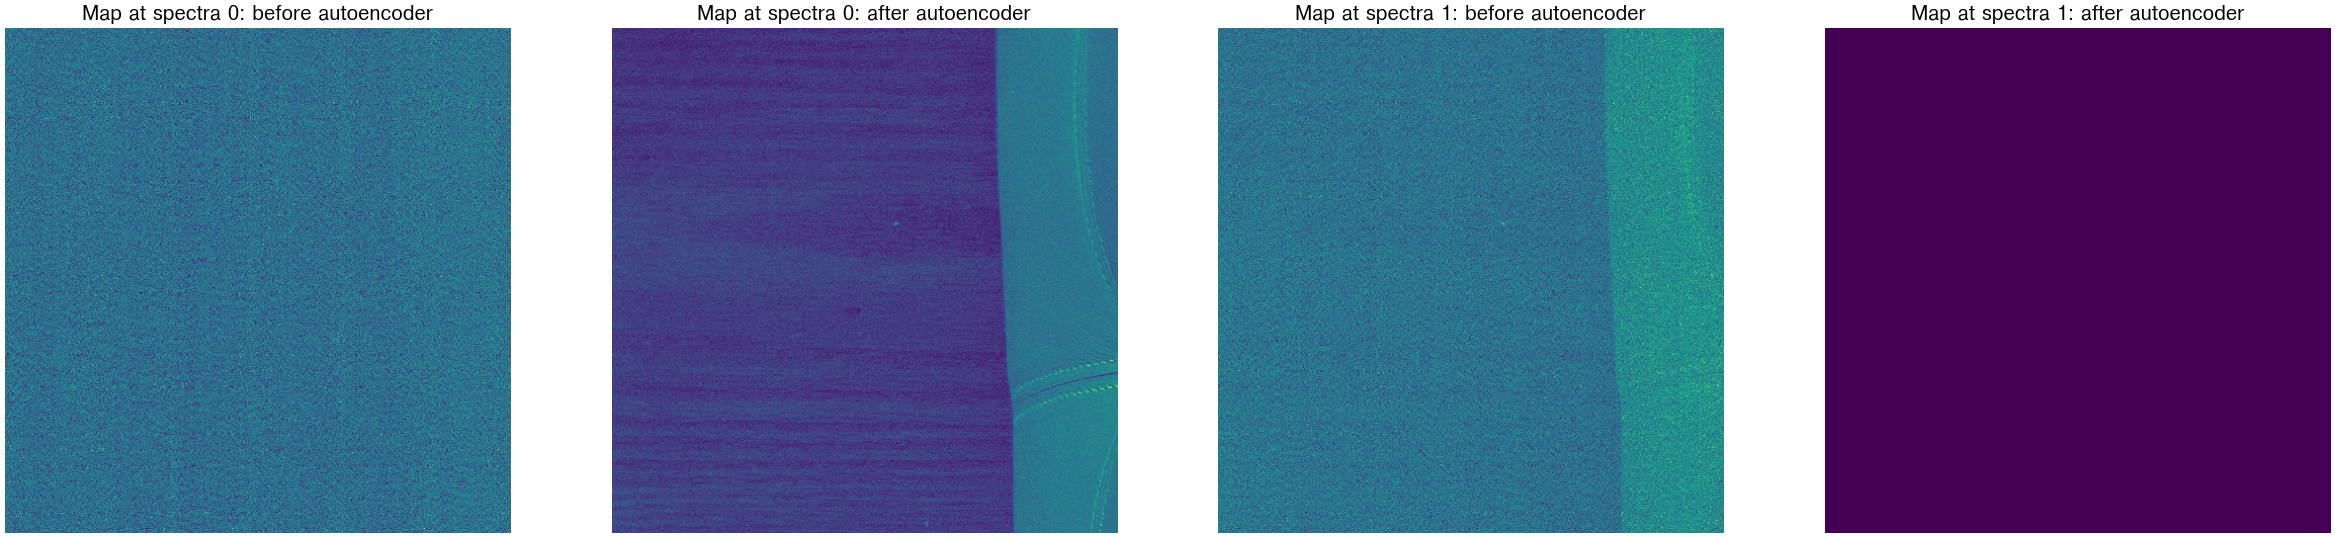

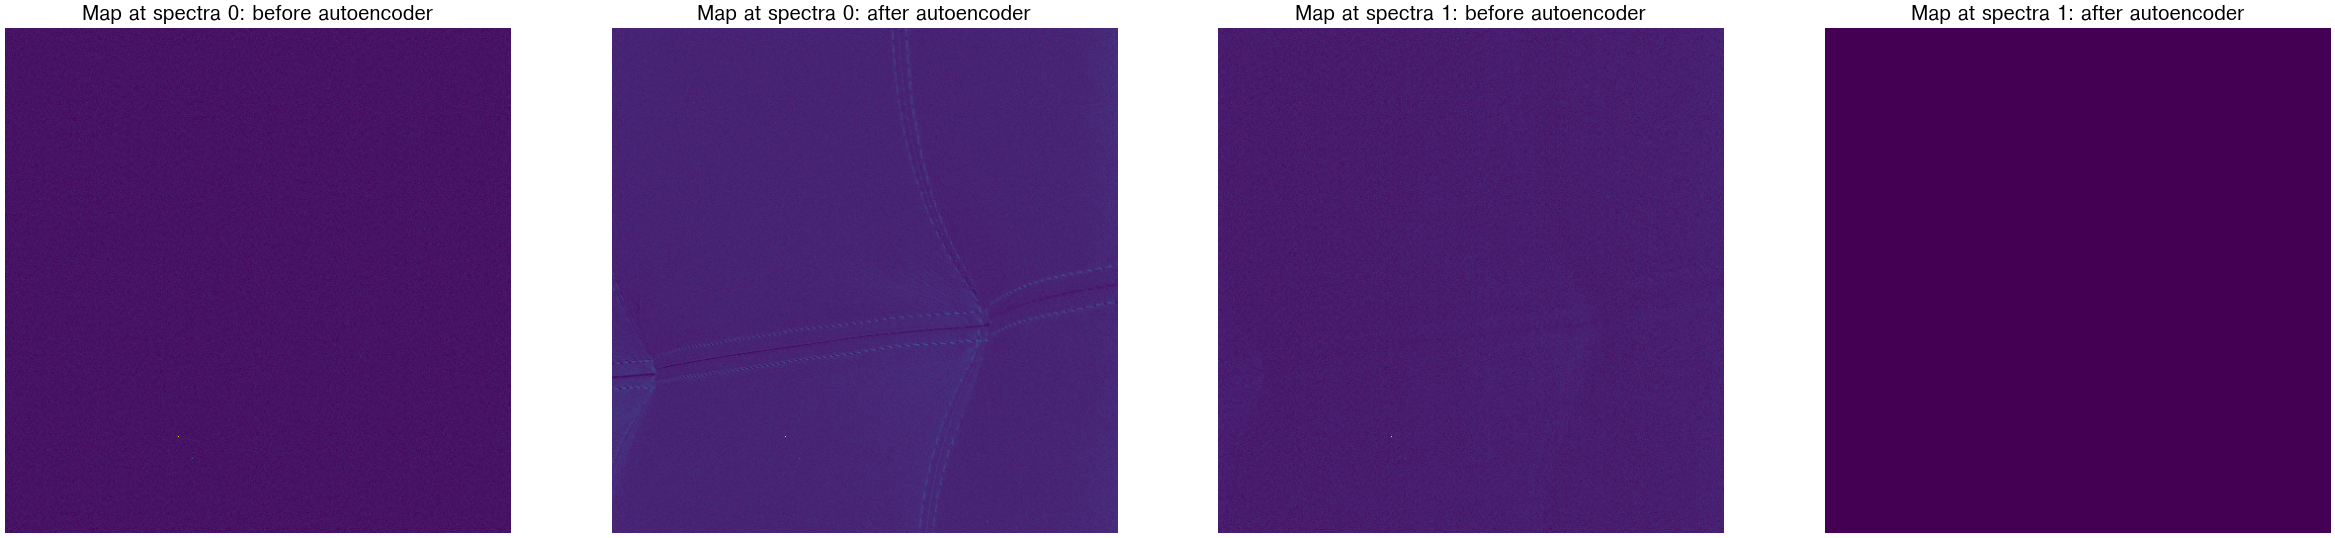

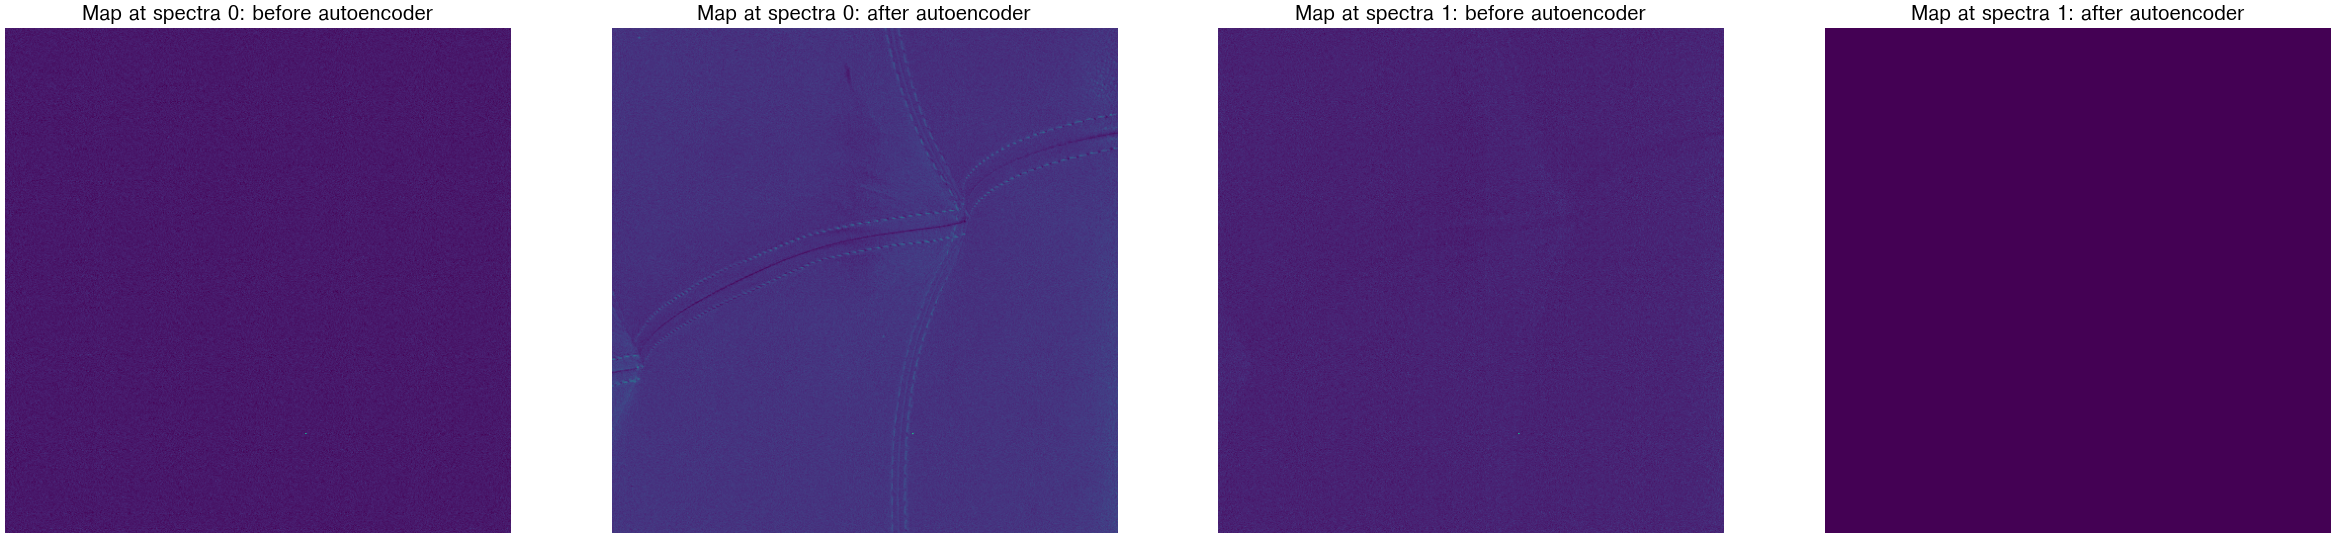

In [5]:
for i in range(4):  
    f, axarr = plt.subplots(1,4, figsize=(30,30))
    
    
    axarr[0].imshow(np.array(cubed_test_images[i,:,:,0]))
    axarr[0].axis('off')
    axarr[0].set_title("Map at spectra 0: before autoencoder")
    
    axarr[1].imshow(np.array(cubed_final_spec[i,:,:,0]))
    axarr[1].axis('off')
    axarr[1].set_title("Map at spectra 0: after autoencoder")
    
    axarr[2].imshow(np.array(cubed_test_images[i,:,:,1]))
    axarr[2].axis('off')
    axarr[2].set_title("Map at spectra 1: before autoencoder")
    
    axarr[3].imshow(np.array(cubed_final_spec[i,:,:,1]))
    axarr[3].axis('off')
    axarr[3].set_title("Map at spectra 1: after autoencoder")
    
    plt.savefig('images/distribution_reconstruction')    

## And here we see the three primary spectra of a hyperspectral image containing mostly wood!

1/1 [==============================] - 0s 388ms/step


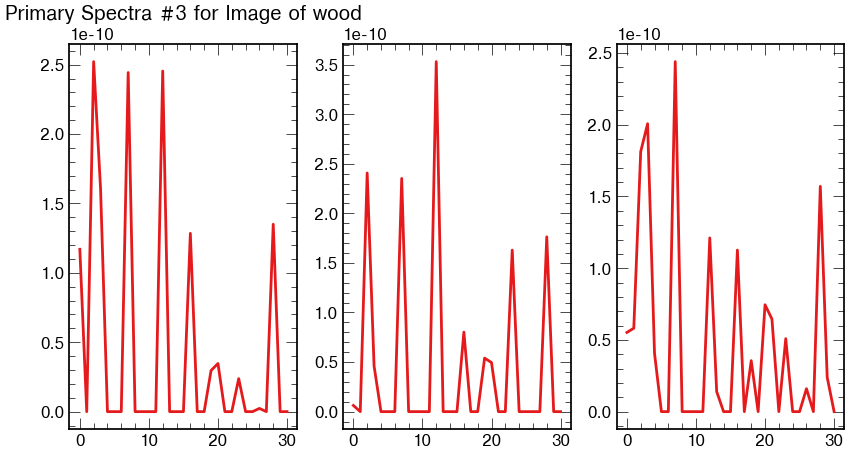

In [16]:
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(input_img)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = MaxPooling1D(pool_size=(1), strides=(2), padding='valid')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = MaxPooling1D(pool_size=(1), strides=(2), padding='valid')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = MaxPooling1D(pool_size=(1), strides=(2), padding='valid')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = MaxPooling1D(pool_size=(1), strides=(2), padding='valid')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = MaxPooling1D(pool_size=(1), strides=(2), padding='valid')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = MaxPooling1D(pool_size=(1), strides=(2), padding='valid')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = MaxPooling1D(pool_size=(1), strides=(2), padding='valid')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = MaxPooling1D(pool_size=(1), strides=(2), padding='valid')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = MaxPooling1D(pool_size=(1), strides=(2), padding='valid')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = MaxPooling1D(pool_size=(1), strides=(2), padding='valid')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = MaxPooling1D(pool_size=(1), strides=(2), padding='valid')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = MaxPooling1D(pool_size=(1), strides=(2), padding='valid')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = MaxPooling1D(pool_size=(1), strides=(2), padding='valid')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = MaxPooling1D(pool_size=(1), strides=(2), padding='valid')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = MaxPooling1D(pool_size=(1), strides=(2), padding='valid')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = MaxPooling1D(pool_size=(1), strides=(3), padding='valid')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = Conv1D(31, (3), activation='relu', padding='same')(encoded_spectra)
encoded_spectra = Dense(31, activation='relu')(encoded_spectra)
encoded_spectra = Dense(31, activation='relu')(encoded_spectra)
encoded_spectra = Dropout(0.2)(encoded_spectra)
encoded_spectra = Dense(31, activation='relu')(encoded_spectra)
encoded_spectra = Dense(31, activation='relu')(encoded_spectra)


## The decoder uses matrix manipulations rather than neural networks
pseudo_inverse = tf.linalg.pinv(encoded_spectra)
material_maps = tf.linalg.matmul(input_img, pseudo_inverse)
positive_forced = tf.nn.relu(material_maps, name ='ReLU')
final_hyperspectral =  tf.linalg.matmul(positive_forced, encoded_spectra)


encoder = Model(inputs=input_img, outputs=(encoded_spectra, material_maps))
primary_spectra, primary_material_maps = encoder.predict(test_images)
primary_material_maps=encube(primary_material_maps)


mat_map_1, mat_map_2, mat_map_3 = primary_material_maps[:,:,:,0], primary_material_maps[:,:,:,1], primary_material_maps[:,:,:,2]
mat_spec_1, mat_spec_2, mat_spec_3 = primary_spectra[:,0,:], primary_spectra[:,1,:], primary_spectra[:,2,:]



f, axarr = plt.subplots(1,3, figsize=(10,5))

axarr[0].plot(mat_spec_1[0,:])
axarr[0].set_title("Primary Spectra #1 for Image of wood")

axarr[1].plot(mat_spec_2[0,:])
axarr[0].set_title("Primary Spectra #2 for Image of wood")

axarr[2].plot(mat_spec_3[0,:])
axarr[0].set_title("Primary Spectra #3 for Image of wood")


plt.savefig('images/primary_spectra')    